# ML - CFA Prediction for A351_S18_LS

### ---Constructor and Definitions---

In [1]:
%matplotlib inline 
import ipywidgets as widgets
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd
import glob
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
# special matplotlib argument for improved plots
from matplotlib import rcParams
import os

rcParams['figure.figsize'] = 18,9
        
def encode_strings(df):
    lb_make = LabelEncoder()
    # LC_type
    df["LC_type_code"] = lb_make.fit_transform(df["LC_type"])
    cols = df.columns.tolist()
    cols.insert(24, cols.pop(cols.index('LC_type_code')))
    df = df.reindex(columns= cols)
    # Thermal
    df["Thermal_code"] = lb_make.fit_transform(df["Thermal"])
    cols = df.columns.tolist()
    cols.insert(26, cols.pop(cols.index('Thermal_code')))
    df = df.reindex(columns= cols)
    # Pressure
    df["Pressure_code"] = lb_make.fit_transform(df["Pressure"])
    cols = df.columns.tolist()
    cols.insert(28, cols.pop(cols.index('Pressure_code')))
    df = df.reindex(columns= cols)  
    # return updated df
    return df

#some general lists to be used later
shell = ['upper', 'lower']
failure_modes_US = ['RF_UL_FF_MS_comp', 'RF_UL_FF_LS', 'RF_UL_W_BUCK', 'RF_UL_FF_LB', 'RF_UL_JOINT_FR_to_CLIP_CL']
failure_modes_LS = ['RF_UL_FF_MS_comp', 'RF_UL_W_MS', 'RF_UL_FF_LS', 'RF_UL_JOINT_FR_to_CLIP_CL', 'RF_UL_JOINT_FR_to_CLIP_FR']

In [34]:
#this function is called for the right feature selection depending on the selected failure mode
def set_features(failure_mode, area):   
    if considered_shell == 'upper':
        if failure_mode == 'RF_UL_FF_LS':
            return ['N_Fr_UL', 'M_Fr_UL', 'T_UL', 'f_x_Skin_L_UL', 'f_z_Skin_L_UL', 
                    'f_xz_Skin_L_UL', 'f_x_Skin_R_UL', 'f_z_Skin_R_UL', 'f_xz_Skin_R_UL', 'mbar',
                    'A_Fr', 'I_Fr', 'EA_Fr', 'yCG_Fr']     
        elif failure_mode == 'RF_UL_FF_LB':
            return ['N_Fr_UL', 'M_Fr_UL',
                    'A_Fr', 'I_Fr', 'yCG_Fr']
        elif failure_mode == 'RF_UL_W_BUCK':
            return ['N_Fr_UL', 'M_Fr_UL', 
                    'T_UL', 'mbar', 'I_Fr', 'EA_Fr', 'yCG_Fr']
        elif failure_mode == 'RF_UL_FF_MS_comp':
            return ['N_Fr_UL', 'M_Fr_UL', 'EA_Fr',
                    'T_GFEM', 'A_Fr', 'I_Fr', 'yCG_Fr', 'mbar']
        elif failure_mode == 'RF_UL_JOINT_FR_to_CLIP_CL':
            return ['N_Fr_UL', 'M_Fr_UL', 'T_UL', 'f_x_Skin_L_UL', 'f_z_Skin_L_UL',
                    'f_xz_Skin_L_UL', 'f_x_Skin_R_UL', 'f_z_Skin_R_UL', 'f_xz_Skin_R_UL',
                    'A_Fr', 'I_Fr', 'EA_Fr', 'yCG_Fr', 'mbar']
        else:
            return ['N_Fr_UL', 'M_Fr_UL', 'T_UL', 'f_x_Skin_L_UL', 'f_z_Skin_L_UL',
                    'f_xz_Skin_L_UL', 'f_x_Skin_R_UL', 'f_z_Skin_R_UL', 'f_xz_Skin_R_UL',
                    'Delta_p_UL', 'T_GFEM', 'A_Fr', 'I_Fr', 'EA_Fr', 'yCG_Fr']
    elif considered_shell == 'lower':
        if failure_mode == 'RF_UL_W_MS':
            return ['N_Fr_UL', 'M_Fr_UL', 'T_UL', 'EA_Fr',
                        'T_GFEM', 'A_Fr', 'I_Fr', 'yCG_Fr']
        elif failure_mode == 'RF_UL_FF_MS_comp':
            return ['N_Fr_UL', 'M_Fr_UL', 'EA_Fr',
                    'T_GFEM', 'A_Fr', 'I_Fr', 'yCG_Fr']
        elif failure_mode == 'RF_UL_FF_LS':
            return ['N_Fr_UL', 'M_Fr_UL', 'T_UL', 'f_x_Skin_L_UL', 'f_z_Skin_L_UL', 
                    'mbar',
                    'f_xz_Skin_L_UL', 'f_x_Skin_R_UL', 'f_z_Skin_R_UL', 'f_xz_Skin_R_UL',
                    'A_Fr', 'I_Fr', 'EA_Fr', 'yCG_Fr']
        elif failure_mode == 'RF_UL_JOINT_FR_to_CLIP_CL':
            return ['N_Fr_UL', 'M_Fr_UL', 'T_UL', 'f_x_Skin_L_UL', 'f_z_Skin_L_UL',
                    'f_xz_Skin_L_UL', 'f_x_Skin_R_UL', 'f_z_Skin_R_UL', 'f_xz_Skin_R_UL',
                    'A_Fr', 'I_Fr', 'EA_Fr', 'yCG_Fr', 'h', 'tw']
        elif failure_mode == 'RF_UL_JOINT_FR_to_CLIP_FR':
            return ['N_Fr_UL', 'M_Fr_UL', 'T_UL', 'f_x_Skin_L_UL', 'f_z_Skin_L_UL',
                    'f_xz_Skin_L_UL', 'f_x_Skin_R_UL', 'f_z_Skin_R_UL', 'f_xz_Skin_R_UL',
                    'Delta_p_UL', 'T_GFEM', 'A_Fr', 'I_Fr', 'EA_Fr', 'yCG_Fr', 'h', 'tw']
        else:
            return ['N_Fr_UL', 'M_Fr_UL', 'T_UL', 'f_x_Skin_L_UL', 'f_z_Skin_L_UL',
                    'f_xz_Skin_L_UL', 'f_x_Skin_R_UL', 'f_z_Skin_R_UL', 'f_xz_Skin_R_UL',
                    'Delta_p_UL', 'T_GFEM', 'A_Fr', 'I_Fr', 'EA_Fr', 'yCG_Fr']

In [3]:
#this function is used for the failure mode dropdown menu, the most critical failure modes are shown depending on 
# which shell is selected
def set_FM(v):
    global considered_shell
    global FMs_curr
    if v == 'Upper shell':
        considered_shell = 'upper'
        FMs_curr = failure_modes_US
    elif v == 'Lower shell':
        considered_shell = 'lower'
        FMs_curr = failure_modes_LS
    elif v == 'Side shell':
        considered_shell = 'side'
        FMs_curr = failure_modes_SS
    else:
        FMs_curr = None

In [4]:
#this function is used to create "RF nice plots"
def create_plot(title, RFmax_plot):
    global xmin
    xmin = 0.4
    global xmax
    xmax = RFmax_plot*1.1
    scatter = 1.05
    scatter2 = 1.1
    plot1 = plt.plot([xmin, xmax], [xmin, xmax], linestyle='-', color = 'r', zorder=0)
    plot1 = plt.plot([xmin, xmax], [xmin*scatter, xmax*scatter], linestyle=':', color = 'b', zorder=0)
    plot1 = plt.plot([xmin, xmax], [xmin/scatter, xmax/scatter], linestyle=':', color = 'b', zorder=0)
    plot1 = plt.plot([xmin, xmax], [xmin*scatter2, xmax*scatter2], linestyle=':', color = 'g', zorder=0)
    plot1 = plt.plot([xmin, xmax], [xmin/scatter2, xmax/scatter2], linestyle=':', color = 'g', zorder=0)
    plot1 = plt.title(title)
    plot1 = plt.legend(loc='best', shadow=False, scatterpoints=1)
    plot1 = plt.ylabel("Calculated Reserve Factor")
    plot1 = plt.xlabel("Predicted Reserve Factor")
    plot1= plt.legend(loc='lower right', shadow=False, scatterpoints=1, prop={'size': 13})
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([xmin,xmax])
    axes.set_aspect(aspect=0.65)

In [5]:
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

### User Input

### -----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [6]:
######### USER INPUT ##############
input_file = 'df_A351_S18_LS_v2.csv'
###################################

In [7]:
RFmax = 4.5

In [8]:
# This widget allows the user to choose between upper and lower shell...
b = widgets.Dropdown(options=['Upper shell', 'Lower shell', 'Side shell'], description='Frame Location:',)
b

Dropdown(description='Frame Location:', options=('Upper shell', 'Lower shell', 'Side shell'), value='Upper she…

In [9]:
# For the previously chosen shell, the relavant failure modes are listed and the user can select the FM to be investigated
set_FM(b.value)
a = widgets.Dropdown(options=FMs_curr, description='Failure Mode:',)
a

Dropdown(description='Failure Mode:', options=('RF_UL_FF_MS_comp', 'RF_UL_W_MS', 'RF_UL_FF_LS', 'RF_UL_JOINT_F…

### -----------------------------------------------------------------------------------------------------------------------------------------------------------------

### Input Data Import

In [52]:
considered_FM = a.value
df = pd.read_csv(input_file).drop(['Unnamed: 0'], axis=1)
df = df.loc[df[considered_FM] != -9999.99]
print('Considered Failure Mode: '+considered_FM)
print(df.shape)
df.head()

Considered Failure Mode: RF_UL_JOINT_FR_to_CLIP_FR
(593244, 42)


,N_Fr_UL,M_Fr_UL,T_UL,f_x_Skin_L_UL,f_z_Skin_L_UL,f_xz_Skin_L_UL,f_x_Skin_R_UL,f_z_Skin_R_UL,f_xz_Skin_R_UL,Delta_p_UL,...,mbar,LoadLoop,GFEM,Location_C2,Location_P2,Location_side,Location,MatType,h,tw
0,35137.80,-17720.300,-3508.410,272.10600,152.65000,22.82440,283.46300,156.81000,12.947500,0.1271,...,1271.0,TLCS,NaN,7201,41,LHS,7201_41_LHS,Compo,107.7,4.34
1,-2705.86,903.125,207.027,-16.05660,-9.00769,-1.34684,-16.72670,-9.25315,-0.764014,-0.0075,...,-75.0,TLCS,NaN,7201,41,LHS,7201_41_LHS,Compo,107.7,4.34
2,3151.44,-24357.000,263.786,1.50181,11.16280,-2.74425,1.13954,10.83710,-0.906818,0.0000,...,0.0,TLCS,NaN,7201,41,LHS,7201_41_LHS,Compo,107.7,4.34
3,2340.00,-14786.700,233.474,1.86450,5.00236,-2.53658,1.70754,4.84652,-0.766206,0.0000,...,0.0,TLCS,NaN,7201,41,LHS,7201_41_LHS,Compo,107.7,4.34
4,2284.47,-14239.600,228.661,1.87314,4.84103,-2.56648,1.73042,4.67756,-0.798638,0.0000,...,0.0,TLCS,NaN,7201,41,LHS,7201_41_LHS,Compo,107.7,4.34


### PLOT!!

In [53]:
df_f1 = df
df_f2 = pd.DataFrame(columns=['RF', 'FM'])

#the following loop only restructures data in oder to use the seaborn "hue" function
for rf in FMs_curr:
    list_curr = df_f1[rf].tolist()
    list2 = [rf]*len(list_curr)
    df_curr2 = pd.DataFrame({'RF':list_curr, 'FM':list2})
    df_f2 = pd.concat([df_f2, df_curr2], ignore_index=True)
df_f2 = df_f2.loc[df_f2['RF'] < 2.5].loc[df_f2['RF'] > 0]
df_f2.head()

,RF,FM
1956,2.35382,RF_UL_FF_MS_comp
1958,2.10237,RF_UL_FF_MS_comp
1983,2.20701,RF_UL_FF_MS_comp
1984,2.46949,RF_UL_FF_MS_comp
1985,1.98446,RF_UL_FF_MS_comp


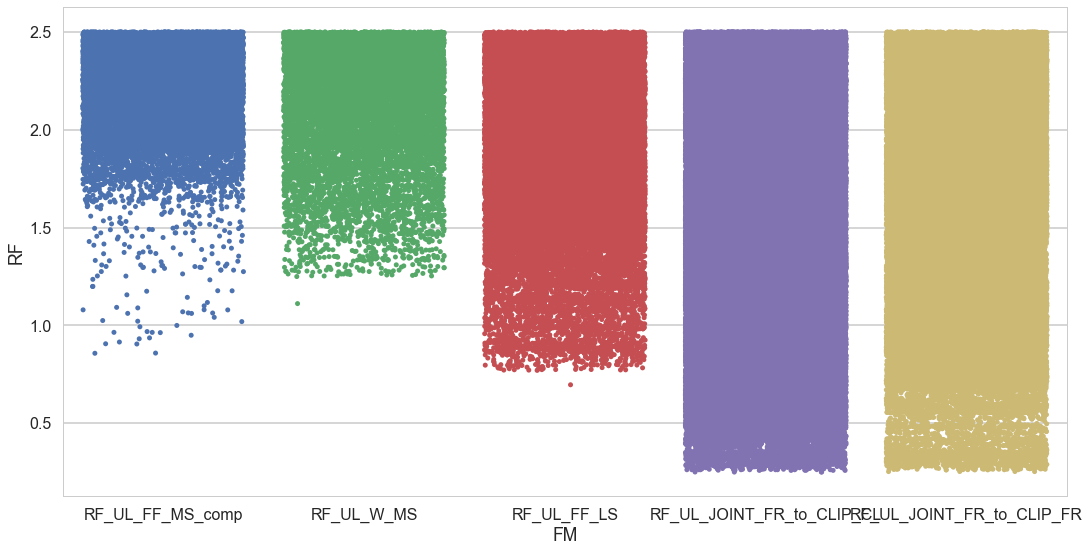

In [54]:
ax = sns.stripplot(x="FM", y="RF", data=df_f2, jitter=0.4)

C:\Users\THA5NF\Documents\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\seaborn\categorical.py:597: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
C:\Users\THA5NF\Documents\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\seaborn\categorical.py:825: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


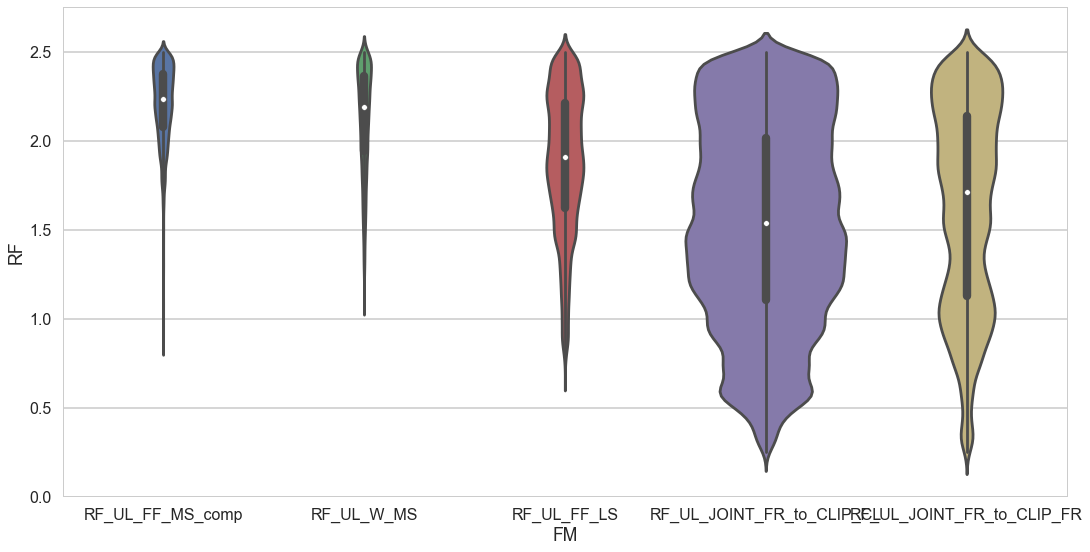

In [55]:
ax = sns.violinplot(x="FM", y="RF", data=df_f2, scale="count")

### Data Preparation

In [56]:
n_pred = 200

In [57]:
features = set_features(considered_FM, considered_shell)
  
result = considered_FM

all_cols = features + [result] + ['LoadLoop']

df_n = df[all_cols].dropna()
df_n = df_n.loc[df_n[considered_FM] < RFmax]

####################################
df_train = df_n.loc[df_n['LoadLoop'] == 'TLCS']
df_test = df_n.loc[df_n['LoadLoop'] == 'FTVL']
######################################

df_train_features = df_train[features]
df_test_features = df_test[features]
df_train_result = df_train[considered_FM]
df_test_result = df_test[considered_FM]
print('Train:')
print('df_feature shape: ',df_train_features.shape)
print('df_result shape: ',df_train_result.shape)
print('Test:')
print('df_feature shape: ',df_test_features.shape)
print('df_result shape: ',df_test_result.shape)

Train:
df_feature shape:  (125062, 17)
df_result shape:  (125062,)
Test:
df_feature shape:  (22157, 17)
df_result shape:  (22157,)


In [58]:
# REMOVE
test_size = 0.1

In [59]:
X_train, y_train, X_test, y_test = df_train_features, df_train_result, df_test_features, df_test_result

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(125062, 17)
(22157, 17)
(125062,)
(22157,)


### Regression

In [60]:
c = widgets.Dropdown(options=['Automatic', 'Preselect'], description='Plot option:',)
c

Dropdown(description='Plot option:', options=('Automatic', 'Preselect'), value='Automatic')

C:\Users\THA5NF\Documents\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Input file: df_A351_S18_LS_v2.csv
No. of training data: 125062
No. of testing data: 22157


,loss (rmse),accuracy (r^2),regressor
0,0.157481,0.980607,Extra_Trees


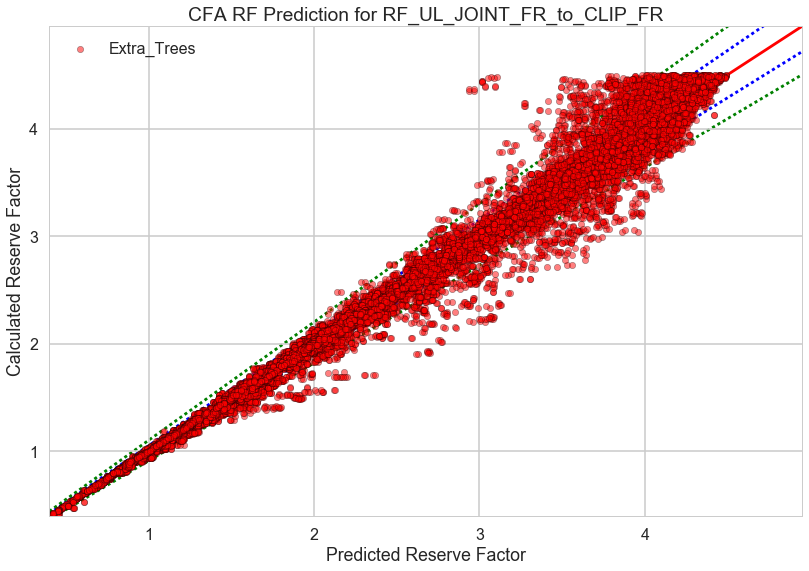

In [61]:
### PLOT SCALING FACTOR ###
# scaling factor < 1 => zoom in, scaling factor > 1 => zoom out
plot_scaling_factor = 1
###########################

if c.value == 'Preselect':
    selected_models = ['Extra_Trees']
elif c.value == 'Automatic':
    selected_models = []
else:
    print('ERROR!!!')
    
                   
rng = np.random.RandomState(1)

regressor = {
#             'Linear_Regression':LinearRegression(),
#             'Decision_Tree':DecisionTreeRegressor(),
#             'Random_Forest':RandomForestRegressor(n_estimators= 90, random_state=rng, oob_score=True),
            'Extra_Trees':ExtraTreesRegressor(n_estimators=50, max_features=None, random_state=rng, criterion='mse',
                                             min_samples_leaf=1),
#             'AdaBoost':AdaBoostRegressor(),
#             'SVM':SVR(kernel='rbf', degree=3, gamma='auto', coef0=0.0, tol=0.001, C=1.0,
#                         epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
            }
    
color=['red', 'yellow', 'blue', 'green', 'pink', 'black']
i, rmse_min = 0, 100000   
summary_df = pd.DataFrame({'regressor':{},'loss (rmse)':{},'accuracy (r^2)':{}}).set_index('regressor')
create_plot('CFA RF Prediction for ' + considered_FM, RFmax*plot_scaling_factor)

for name, r in regressor.items():
    r.fit(X_train, y_train)
    y_prediction_curr = r.predict(X_test)
    rmse_curr, r2_curr = np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_prediction_curr)), r2_score(y_test, y_prediction_curr)
    if rmse_curr < rmse_min:
        rmse_min = rmse_curr
        y_prediction_best = y_prediction_curr
        best_regressor = name
        color_auto = color[i]
    summary_df = summary_df.append({'regressor':name,'loss (rmse)':rmse_curr,'accuracy (r^2)':r2_curr}, ignore_index=True)
    if name in selected_models:
        plt.scatter(y_prediction_curr, y_test, s=40, c=color[i], alpha=0.5, edgecolor='k', label=name)
    i = i + 1
if c.value == 'Automatic':
    plt.scatter(y_prediction_best, y_test, s=40, c=color_auto, alpha=0.5, edgecolor='k', label=best_regressor)
plt.legend(loc='best', shadow=False, scatterpoints=1)
summary_df = summary_df.sort_values('loss (rmse)',ascending=True).reset_index().drop(['index'], axis=1)
print('Input file: ' + input_file)
# print('Test size: ' + str(test_size))
print('No. of training data: ' + str(y_train.shape[0]))
print('No. of testing data: ' + str(y_test.shape[0]))
summary_df

### Feature Importance

Feature importance for best regressor: Extra_Trees


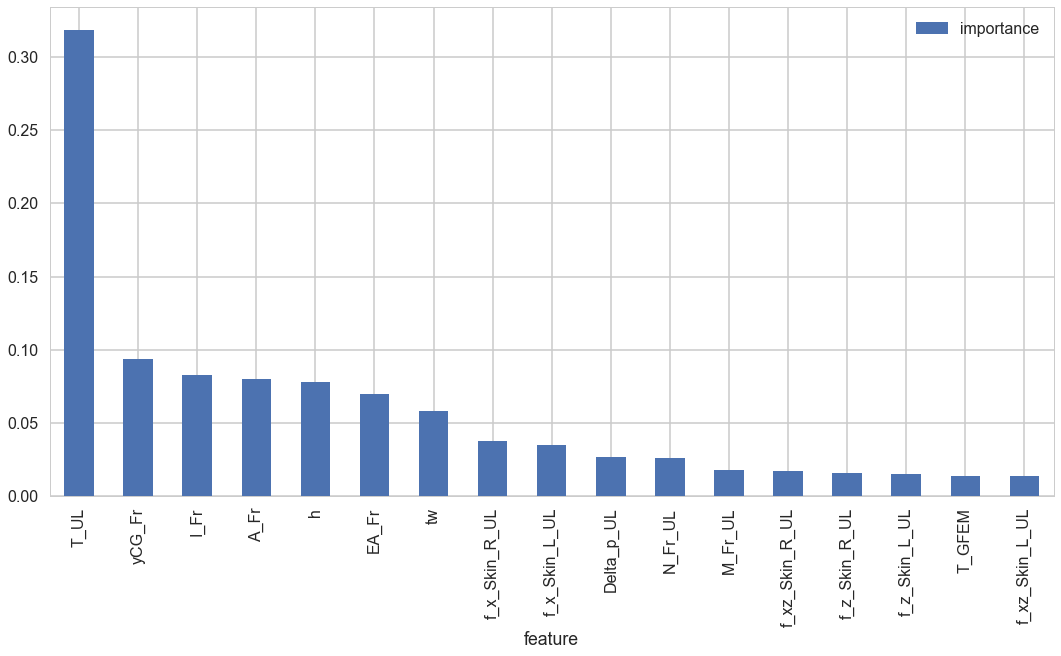

In [62]:
print('Feature importance for best regressor: ' + best_regressor)
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(regressor[best_regressor].feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()

### Extrapolation Threshold

In [63]:
y_test_list = y_test.tolist()
y_pred_list = y_prediction_best.tolist()

In [64]:
df_th = pd.DataFrame({'RF_calculated':{},'RF_predicted':{}, 'Failure Mode':{}})
df_th['RF_calculated'] = pd.Series(y_test_list)
df_th['RF_predicted'] = pd.Series(y_pred_list)
df_th['Failure Mode'] = considered_FM
RFmax_extrapol = RFmax-1
df_th = df_th.loc[df_th['RF_predicted'] < RFmax_extrapol]
df_th.head()

,RF_calculated,RF_predicted,Failure Mode
110,3.4983,3.481993,RF_UL_JOINT_FR_to_CLIP_FR
111,3.4600,3.447891,RF_UL_JOINT_FR_to_CLIP_FR
113,3.3365,3.401611,RF_UL_JOINT_FR_to_CLIP_FR
114,3.3024,3.389470,RF_UL_JOINT_FR_to_CLIP_FR
115,3.4292,3.412268,RF_UL_JOINT_FR_to_CLIP_FR


C:\Users\THA5NF\Documents\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


14733
accuracy (r^2): 0.978632529313
loss (rmse): 0.124446503758


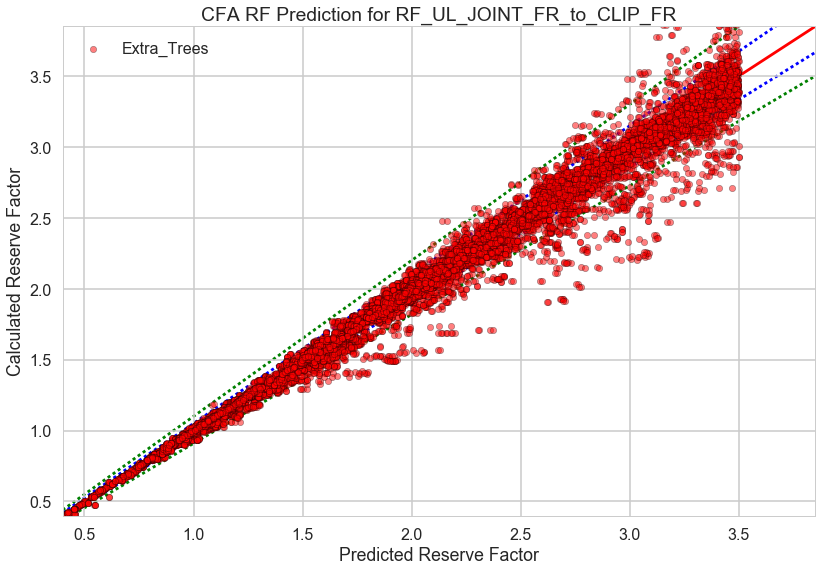

In [65]:
### PLOT SCALING FACTOR ###
# scaling factor < 1 => zoom in, scaling factor > 1 => zoom out
plot_scaling_factor = 1
###########################

create_plot('CFA RF Prediction for ' + considered_FM, RFmax_extrapol*plot_scaling_factor)
plt.scatter(df_th['RF_predicted'], df_th['RF_calculated'], s=40, c=color_auto, alpha=0.5, edgecolor='k', label=best_regressor)
plt.legend(loc='best', shadow=False, scatterpoints=1)
rmse_th, r2_th = np.sqrt(sklearn.metrics.mean_squared_error(df_th['RF_calculated'], df_th['RF_predicted'])), r2_score(df_th['RF_calculated'], df_th['RF_predicted'])
print(len(df_th))
print('accuracy (r^2): ' + str(r2_th))
print('loss (rmse): ' + str(rmse_th))

accuracy (r^2): 0.978632529313
loss (rmse): 0.124446503758


C:\Users\THA5NF\Documents\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


str

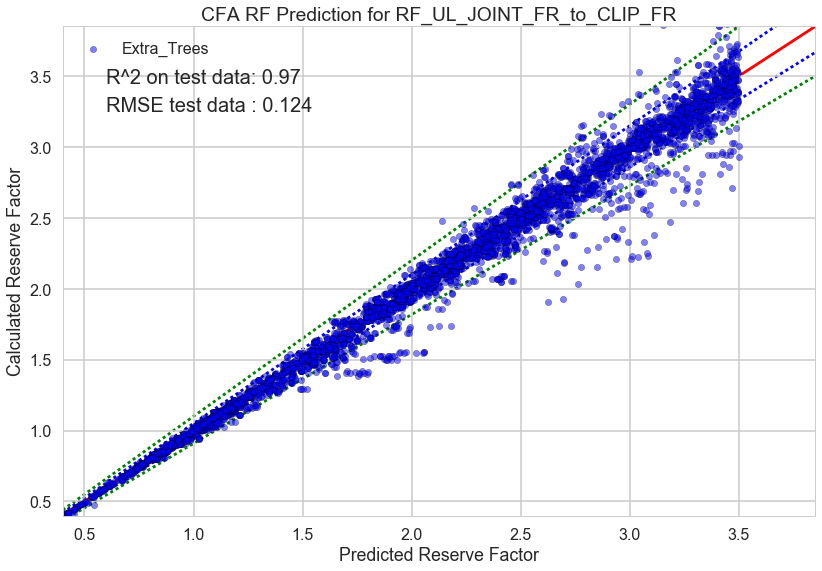

In [66]:
### PLOT SCALING FACTOR ###
# scaling factor < 1 => zoom in, scaling factor > 1 => zoom out
plot_scaling_factor = 1
scalor = int((len(df_th)/4000))
if scalor == 0:
    df_thred = df_th
else:
    df_thred = df_th[df_th.index % scalor == 0]
r2_th2 = truncate(r2_th,2)
###########################

create_plot('CFA RF Prediction for ' + considered_FM, RFmax_extrapol*plot_scaling_factor)
plt.scatter(df_thred['RF_predicted'], df_thred['RF_calculated'], s=40, c='b', alpha=0.5, edgecolor='k', label=best_regressor)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.text(xmin + 0.2, xmax-0.4, ("R^2 on test data: " + r2_th2), fontsize=20)
plt.text(xmin + 0.2, xmax-0.6, (str("RMSE test data : %.3f" % rmse_th)), fontsize=20)
#rmse_th, r2_th = np.sqrt(sklearn.metrics.mean_squared_error(df_th['RF_calculated'], df_th['RF_predicted'])), r2_score(df_th['RF_calculated'], df_th['RF_predicted'])

print('accuracy (r^2): ' + str(r2_th))
print('loss (rmse): ' + str(rmse_th))
type(r2_th2)

### Nice Plot Routine

In [67]:
# note that these methods reqires several iterations of the above steps (for each failure mode to be investigated)
df_np = pd.DataFrame()
#first iteration

# df_np = df_th

#afterwards

df_np = pd.concat([df_np, df_th], ignore_index=False)